# Machine Vision<br>Assignment 7 - Hough transform

## Personal details

* **Name(s):** ``
* **Student ID(s):** ``

## 1. Introduction

In this assignment we use the Hough transform to extract circles from images. We will implement a simple Hough transform. Note that there are more robust ways of implementing it but they are also more complicated. The Hough transform consists of 4 basic steps: detect edge pixels, accumulate votes, filter the accumulator, and extract objects. We will perform these steps in the following sections. Refer to the lecture notes for more information about the Hough transform.

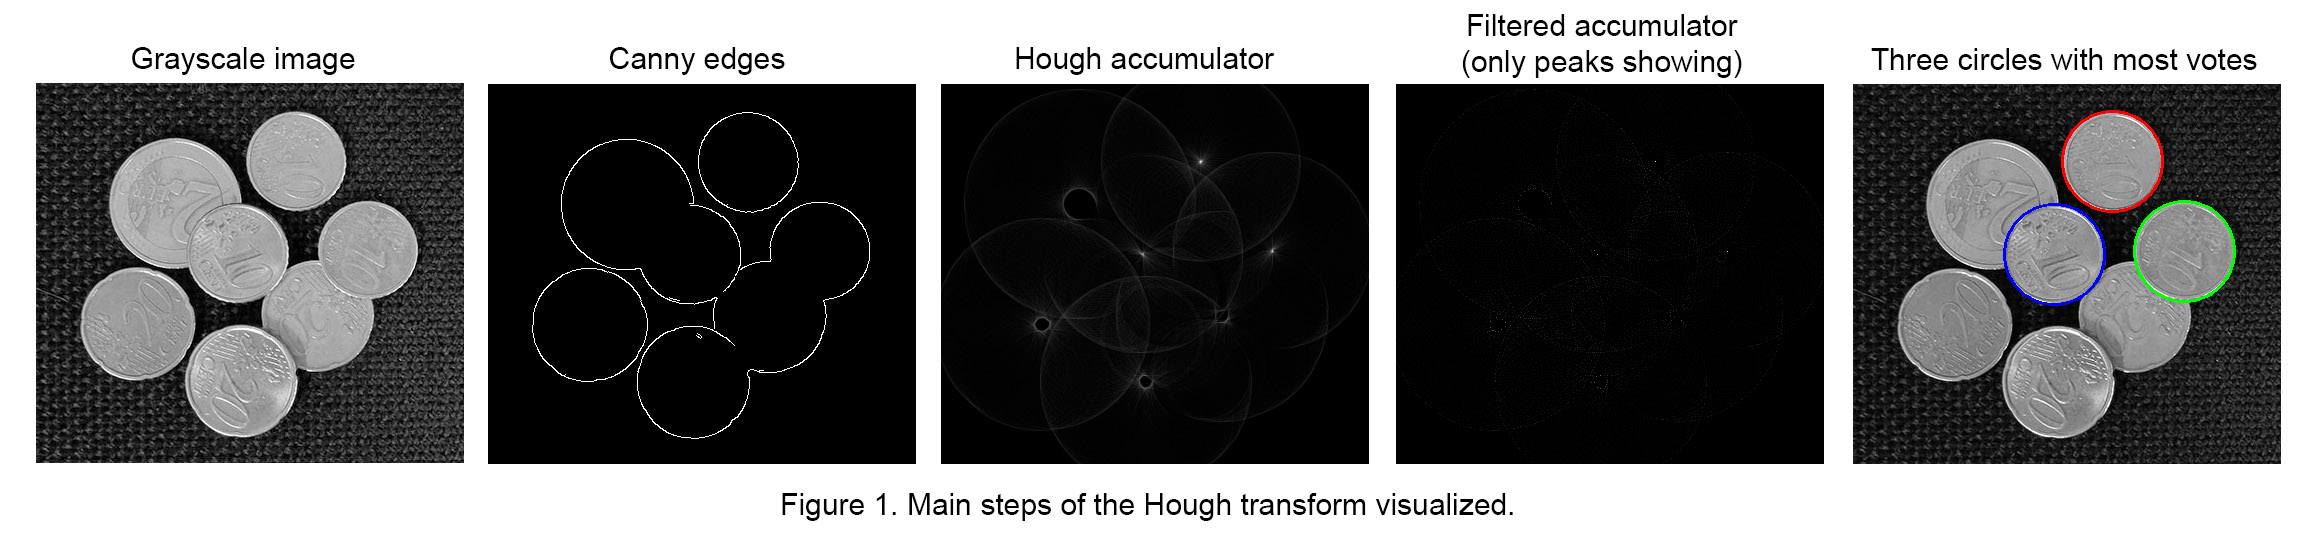

## 2. Finding circles with known radius

In this section, we use the Hough transform to find circles with known radius. Specifically, we want to extract 10 cent coins as in Figure 1.

**2.1. Detect edge pixels** $\quad$ <font color=red>(0.50 points)</font>

The first step is to select which pixels will cast votes. You should extract edge points using the Canny edge detector. You can use the OpenCV function __[`cv2.canny()`](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html)__. The sample code __[`2DModels.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/2DModels.ipynb)__ shows you how to use this function. *Note:* You only want to detect edges (borders) of the coins similar to Figure 1. Avoid detecting non-edge pixels. Try different threshold values and choose parameters that you think work best.

(-0.5, 427.5, 379.5, -0.5)

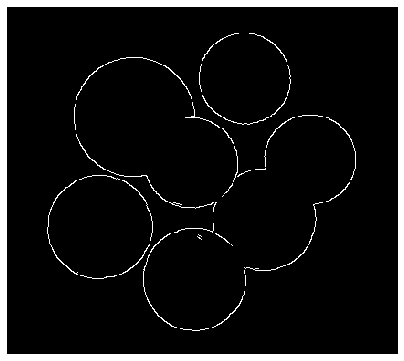

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('images/coins.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# ---------- YOUR CODE STARTS HERE -----------
edges = cv2.Canny(img,390,800)
plt.figure(figsize=(7,7))
plt.imshow(edges, cmap='gray')
plt.axis('off')

# ----------- YOUR CODE ENDS HERE ------------

**2.2. Accumulate votes**  $\quad$ <font color=red>(0.50 points)</font>

A circle has three parameters: the radius $d$, the row-coordinate of the center $r_0$ and the column-coordinate of the center $c_0$. Circles are represented by the equations:

$$
r = r_0 + d \, \text{sin} \theta \qquad \qquad (1) \\
c = c_0 + d \, \text{cos} \theta \qquad \qquad (2)
$$

Our goal is to find circles from images. Let us first consider the case when radius $d$ is fixed. In such case, we only need to find the center of the circle:

$$
r_0 = r - d \, \text{sin} \theta \qquad \qquad (3) \\
c_0 = c - d \, \text{cos} \theta \qquad \qquad (4)
$$

In the previous section, we detected edge pixels that hopefully belong to a circle. Let $(c, r)$ be one of those edge points. By varying $\theta$ from $0$ to $2\pi$ we can compute all possible circles $(c_0, r_0)$ that this point may belong. The following code illustrates this given three points. In this case, each of the points actually belongs to the same circle. Run the code and observe how each point generates a circle to the Hough parameter space.

Text(0.5, 1.0, 'Hough space')

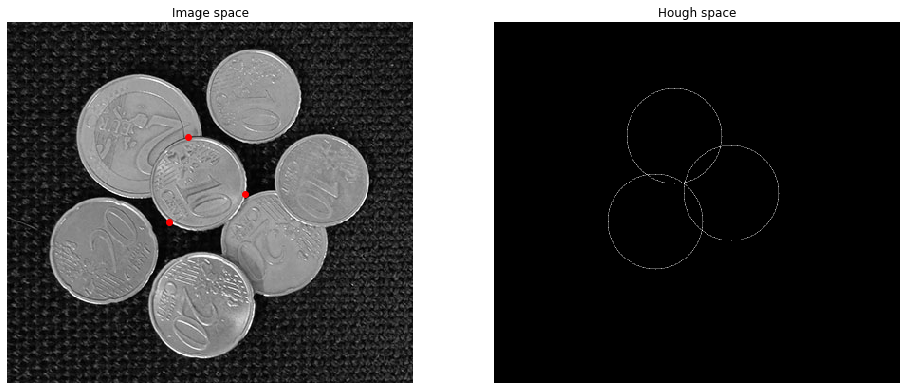

In [2]:
d = 50 # Radius is fixed (10 cent coin)

# Three points that belong to a circle
pts = np.array([[170,210],  # Point 1
                [190,120],  # Point 2
                [250,180]]) # Point 3

# Initialize accumulator
height, width = img.shape
A = np.zeros((height,width), dtype=np.float_)

# Theta goes from 0 to 2*pi (1 degree increments). 
thetas = np.linspace(0,2*np.pi,360,endpoint=False)

for c, r in pts:
    for theta in thetas:
    
        
        r0 = r - d*np.sin(theta) # Eq. 3
        c0 = c - d*np.cos(theta) # Eq. 4
    
        # Accumulate votes
        A[int(r0),int(c0)] += 1

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.plot(pts[:,0],pts[:,1],'ro')
plt.axis('off')
plt.title('Image space')
plt.subplot(122)
plt.imshow(A, cmap='gray')
plt.axis('off')
plt.title('Hough space')

Complete the following code cell. You should build a Hough accumulator using the edge points you detected previously. The sample code above will help you to complete this task. Only minor changes are needed. Display the accumulator (it should look similar to the accumulator in Figure 1). *Note! We still use the accumulator `A` so do not overwrite it.*

Text(0.5, 1.0, 'Hough accumulator')

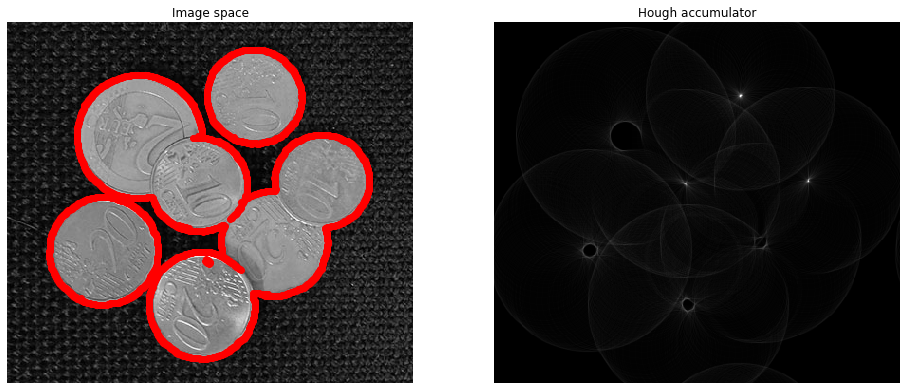

In [3]:
# ---------- YOUR CODE STARTS HERE -----------
d = 50 # Radius is fixed (10 cent coin)

coor = np.array(np.argwhere(edges!=0))

# Initialize accumulator
height, width = img.shape
B = np.zeros((height,width), dtype=np.float_)

# Theta goes from 0 to 2*pi (1 degree increments). 
thetas = np.linspace(0,2*np.pi,360,endpoint=False)

for r, c in coor:
    for theta in thetas:
    
        # Angle has to be in radians
        r0 = r - d*np.sin(theta) # Eq. 3
        c0 = c - d*np.cos(theta) # Eq. 4
    
        # Accumulate votes
        if r0 < B.shape[0] and c0 < B.shape[1] :
            B[int(r0),int(c0)] += 1

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.plot(coor[:,1],coor[:,0],'ro')
plt.axis('off')
plt.title('Image space')
plt.subplot(122)
plt.imshow(B, cmap='gray')
plt.axis('off')
plt.title('Hough accumulator')





# ----------- YOUR CODE ENDS HERE ------------

*Hints:* 
- Make sure you do not access the values outside the accumulator. For example: A[400,400] += 1 would produce an error.
- You can use `cv2.findNonZeros()` to extract row and column coordinates of the edge points. See the sample code __[`2DModels.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/2DModels.ipynb)__.

**2.3. Extract circles** $\quad$ <font color=red>(0.50 points)</font>

Take a look at the accumulator `A` that was generated from the three points. Notice that all circles intersect at the same point (more or less). This point will have the most votes in the accumulator. If we extract the coordinates of that point, we find the most voted circle. The following code demonstrates this.

Text(0.5, 1.0, 'A circle with most votes')

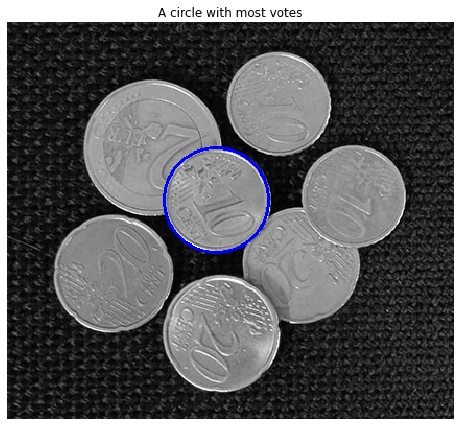

In [4]:
# Find a circle that has most votes
idx = np.argsort(-A, axis=None) # Descending order: -A
r0, c0 = np.unravel_index(idx, A.shape)

# Use OpenCV to draw the first circle
circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.circle(circles,(c0[0],r0[0]),d,(0,0,255),2)

plt.figure(figsize=(8,8))
plt.imshow(circles, cmap='gray')
plt.axis('off')
plt.title('A circle with most votes')

Complete the following code cell. Extract 3 most voted circles from the accumulator you generated in the previous section. The sample code above will help you to complete this task. Use different colors when drawing the circles. You will notice that two of the circles are pretty much the same but slightly shifted.

Text(0.5, 1.0, 'A & B circle with most votes')

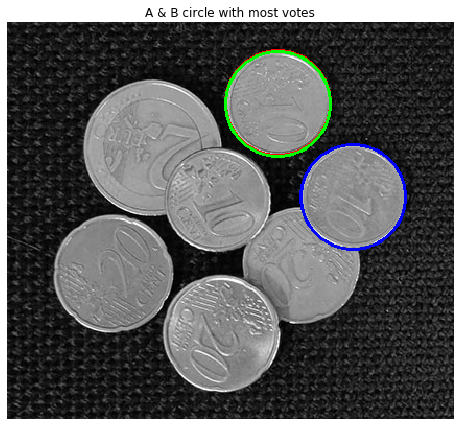

In [5]:
# ---------- YOUR CODE STARTS HERE -----------

# Find a circle that has most votes
idx1 = np.argsort(-B, axis=None) # Descending order: -A
r1, c1 = np.unravel_index(idx1, B.shape)

circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Use OpenCV to draw the top three circles
cv2.circle(circles,(c1[0],r1[0]),d,(255,0,0),2)
cv2.circle(circles,(c1[1],r1[1]),d,(0,255,0),2)
cv2.circle(circles,(c1[2],r1[2]),d,(0,0,255),2)

plt.figure(figsize=(8,8))
plt.imshow(circles, cmap='gray')
plt.axis('off')
plt.title('A & B circle with most votes')



# ----------- YOUR CODE ENDS HERE ------------

**2.4. Filter the accumulator** $\quad$ <font color=red>(0.50 points)</font>

The previous issue happens because we have not filtered the accumulator and votes have been cast on neighbouring bins. Perform a non-maxima suppression on the accumulator. Use the provided function `nms()` to produce a second accumulator with only maxima values. Display the filtered accumulator. Extract 3 most voted circles the same way you did earlier. You should be able to extract each of the 10 cent coins as in Figure 1.

Text(0.5, 1.0, 'A & B circle with most votes')

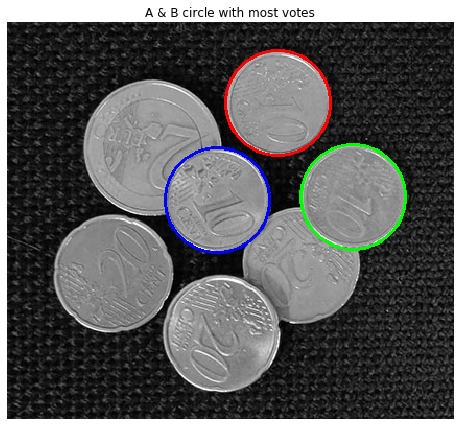

In [6]:
# Non-maxima suppression. This simple simple function
# works in this case. Values that are not local maxima
# are set to zero.
def nms(accum):
    accum_filt = accum.copy()
    mi = accum.min()
    dil = cv2.dilate(accum_filt, None)
    accum_filt[accum_filt < dil] = mi
    return(accum_filt)


# ---------- YOUR CODE STARTS HERE -----------

# Produce a second accumulator
B2 = nms(B)

# Find a circle that has most votes
idx1 = np.argsort(-B2, axis=None) # Descending order: -A
r1, c1 = np.unravel_index(idx1, B2.shape)

circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Use OpenCV to draw the top three circles
cv2.circle(circles,(c1[0],r1[0]),d,(255,0,0),2)
cv2.circle(circles,(c1[1],r1[1]),d,(0,255,0),2)
cv2.circle(circles,(c1[2],r1[2]),d,(0,0,255),2)

plt.figure(figsize=(8,8))
plt.imshow(circles, cmap='gray')
plt.axis('off')
plt.title('A & B circle with most votes')




# ----------- YOUR CODE ENDS HERE ------------

## 3. Finding circles with unknown radius

It is also possible to find circles with unknown radius by using a three dimensional accumulation matrix. We could specify a range of radius values (e.g. $d = [1,200]$ pixels). When building the accumulator (Section 2.2.) we could loop through all possible radius values. The maximum value in the 3D accumulator would correspond to the most voted circle. A direct implementation of such approach would be very slow. Let us use the OpenCV implementation instead to find all coins from the image.

Text(0.5, 1.0, 'OpenCV (HoughCircles)')

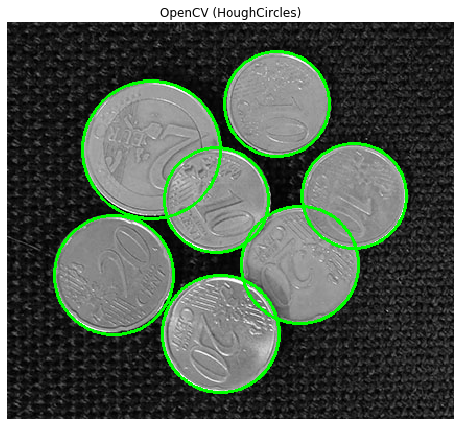

In [7]:
filtered = cv2.medianBlur(img,5)
circles = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

C = cv2.HoughCircles(filtered,cv2.HOUGH_GRADIENT,1,30,
                     param1=400,param2=30,minRadius=1,maxRadius=200)
C = np.uint16(np.around(C))

# Draw circles with most votes
for i in C[0,:]:
    cv2.circle(circles,(i[0],i[1]),i[2],(0,255,0),2)

plt.figure(figsize=(8,8))
plt.imshow(circles)
plt.axis('off')
plt.title('OpenCV (HoughCircles)')

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`2 hours.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`At first, the result seems like wrong. And then, I found that x and y coordinates are inverse in my code.`

# References
`None!`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A7.ipynb` file) into **`MV_A7_[student number(s)].zip`** (e.g. `MV_A7_1234567.zip` if solo work or `MV_A7_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A7_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 3.3.2019**